## Statistical-Text-Analysis 

In [66]:
import os
import nltk
import pandas as pd
import numpy as np
import matplotlib as plt
from matplotlib.pyplot import figure
from matplotlib import style
style.use('ggplot')
import re

In [2]:
# Change the current directory to read the data
os.chdir(r"C:\Users\Sultan\Desktop\data\PreprocessedData") 

#### Read the data

In [84]:
#Read csv file into a dataframe
df = pd.read_csv(r'CombinedData.csv', engine='python')

In [4]:
df.head()

,ï»¿word,organization,year
0,fiscal,Guilford County,FY2013
1,year,Guilford County,FY2013
2,adopted,Guilford County,FY2013
3,budget,Guilford County,FY2013
4,brenda,Guilford County,FY2013


In [85]:
# Rename col 0
df.columns = ['word','organization','year']
df.head()

,word,organization,year
0,fiscal,Guilford County,FY2013
1,year,Guilford County,FY2013
2,adopted,Guilford County,FY2013
3,budget,Guilford County,FY2013
4,brenda,Guilford County,FY2013


In [86]:
df['year'].value_counts()

FY2017    419031
FY2020    416519
FY2016    411459
FY2018    407995
FY2015    395117
FY2014    388053
FY2013    383771
FY2019    362319
Name: year, dtype: int64

#### Creating Pandas Series out of the word col

In [7]:
text = df.word
text.head()

0     fiscal
1       year
2    adopted
3     budget
4     brenda
Name: word, dtype: object

#### Extract all elements from the series

In [8]:
# Join the elements and sperate them by a single space
corpus = ' '.join(word for word in text)

In [9]:
len(corpus)

26796670

In [10]:
corpus[:196] # Let's see the first 196 chars in the series

'fiscal year adopted budget brenda jones county manager sharisse fuller assistant county managerhuman resources director prepared office budget management evaluation michael halford budget director'

#### Tokenizing +  Building bigrams 

In [11]:
# Tokenize
tokens = nltk.word_tokenize(corpus)

# Create bigrams
bgs = nltk.bigrams(tokens)

#### Computing raw frequency of the bigrams

In [12]:
# Compute frequency distribution for all the bigrams in the corpus
bgs_fdist = nltk.FreqDist(bgs)

# Convert nltk freq dist to dictonary
bgs_fdistDic = bgs_fdist.items()

#### Creating a data frame out of the dictionary 

In [13]:
bgs_fdist_df = pd.DataFrame.from_dict(bgs_fdistDic)
bgs_fdist_df.columns = ['bigram','frequency']
bgs_fdist_df.head()

,bigram,frequency
0,"(fiscal, year)",8461
1,"(year, adopted)",4405
2,"(adopted, budget)",7968
3,"(budget, brenda)",1
4,"(brenda, jones)",2


#### Adding the bigrams and their frequency score to the original dataframe

In [14]:
df['bigram'] = bgs_fdist_df['bigram']
df['bigram frequency'] = bgs_fdist_df['frequency']

#### Creating trigrams & computing their frequency

In [15]:
# Create trigrams
tgs = nltk.trigrams(tokens)

In [16]:
# Compute frequency distribution for all the trigrams in the corpus
tgs_fdist = nltk.FreqDist(tgs)

# Convert nltk freq dist to dictonary
tgs_fdistDic = tgs_fdist.items()

In [17]:
tgs_fdist_df = pd.DataFrame.from_dict(tgs_fdistDic)
tgs_fdist_df.columns = ['trigram','frequency']

In [18]:
df['trigram'] = tgs_fdist_df['trigram']
df['trigram frequency'] = tgs_fdist_df['frequency']

#### Sort the frequency distributions in a descending order

In [19]:
df_bgsBased = df.sort_values('bigram frequency', ascending= False)
df_tgsBased = df.sort_values('trigram frequency', ascending= False)

In [20]:
df_bgsBased.head(10)

,word,organization,year,bigram,bigram frequency,trigram,trigram frequency
5926,health,Guilford County,FY2013,"(adopted, adopted)",10083.0,"(pcroftsdgfld, emerg, svcs)",1.0
0,fiscal,Guilford County,FY2013,"(fiscal, year)",8461.0,"(fiscal, year, adopted)",4267.0
2,adopted,Guilford County,FY2013,"(adopted, budget)",7968.0,"(adopted, budget, brenda)",1.0
88,budgeting,Guilford County,FY2013,"(general, fund)",7145.0,"(revenues, expenditures, changes)",221.0
113,expenditures,Guilford County,FY2013,"(debt, service)",5748.0,"(debt, human, services)",28.0
86,structure,Guilford County,FY2013,"(fund, balance)",5666.0,"(accounting, summary, revenues)",3.0
84989,surfacing,Durham City,FY2013,"(wake, county)",5234.0,"(approximately, invoices, year)",8.0
1,year,Guilford County,FY2013,"(year, adopted)",4405.0,"(year, adopted, budget)",4293.0
51157,property,Charlotte City,FY2013,"(durham, county)",4317.0,"(resources, ease, transition)",2.0
670,revised,Guilford County,FY2013,"(north, carolina)",4081.0,"(overlay, colfax, fire)",49.0


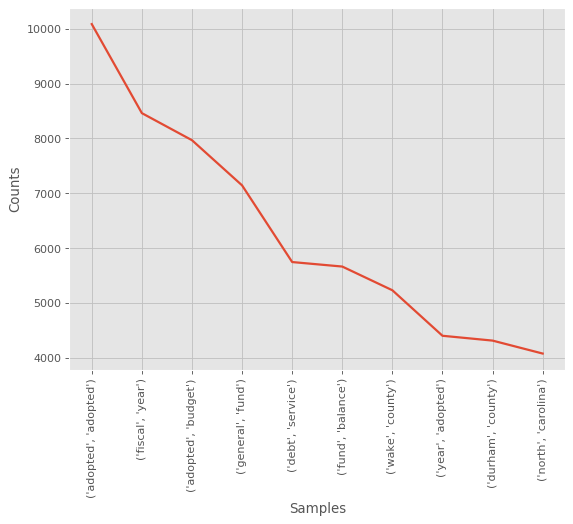

In [21]:
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
bgs_fdist.plot(10, cumulative=False)

In [22]:
df_tgsBased.head(10)

,word,organization,year,bigram,bigram frequency,trigram,trigram frequency
10015,countys,Guilford County,FY2013,"(purpose, board)",12.0,"(adopted, adopted, adopted)",4680.0
1,year,Guilford County,FY2013,"(year, adopted)",4405.0,"(year, adopted, budget)",4293.0
0,fiscal,Guilford County,FY2013,"(fiscal, year)",8461.0,"(fiscal, year, adopted)",4267.0
169311,positions,Durham County,FY2013,"(dental, description)",7.0,"(benefits, contractual, services)",2664.0
159133,full,Durham County,FY2013,"(foundation, longerterm)",6.0,"(total, revenue, county)",2474.0
169320,increases,Durham County,FY2013,"(care, serving)",3.0,"(revenue, county, dollars)",2233.0
169312,approved,Durham County,FY2013,"(description, promote)",9.0,"(contractual, services, commodities)",2231.0
169500,team,Durham County,FY2013,"(instructions, patient)",1.0,"(actual, actual, target)",2066.0
169508,fiscal,Durham County,FY2013,"(wchs, exceeded)",1.0,"(overview, adopted, adopted)",2057.0
169513,technology,Durham County,FY2013,"(individuals, patients)",8.0,"(adopted, adopted, position)",2030.0


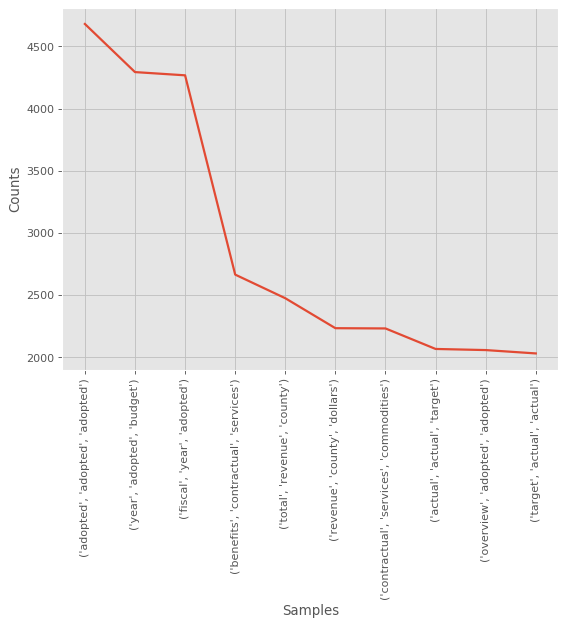

In [23]:
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
tgs_fdist.plot(10, cumulative=False)

In [87]:
# Let's take a look at our data frame 
df.head()

,word,organization,year
0,fiscal,Guilford County,FY2013
1,year,Guilford County,FY2013
2,adopted,Guilford County,FY2013
3,budget,Guilford County,FY2013
4,brenda,Guilford County,FY2013


In [89]:
# Now let's select the data entries from columns 'word' and 'organization' that 
# has the label FY2020 and store it in a different dataframe
FY20_df = df.loc[df['year'] == 'FY2020', ['word', 'organization', 'year']]
FY20_df.head()

,word,organization,year
2767745,guilford,Guilford County,FY2020
2767746,county,Guilford County,FY2020
2767747,numbers,Guilford County,FY2020
2767748,makes,Guilford County,FY2020
2767749,count,Guilford County,FY2020


In [90]:
# Let's apply the same logic to the other organizations
gc_df      = FY20_df.loc[FY20_df['organization'] == 'Guilford County', ['word', 'organization']]
cc_df      = FY20_df.loc[FY20_df['organization'] == 'Charlotte City', ['word', 'organization']]
dcity_df   = FY20_df.loc[FY20_df['organization'] == 'Durham City', ['word', 'organization']]
dcounty_df = FY20_df.loc[FY20_df['organization'] == 'Durham County', ['word', 'organization']]
mc_df      = FY20_df.loc[FY20_df['organization'] == 'Mecklenburg County', ['word', 'organization']]
rc_df      = FY20_df.loc[FY20_df['organization'] == 'Raleigh City', ['word', 'organization']]
wc_df      = FY20_df.loc[FY20_df['organization'] == 'Wake County', ['word', 'organization']]

In [91]:
corpus  = gc_df.word
corpus1 = cc_df.word
corpus2 = dcity_df.word
corpus3 = dcounty_df.word
corpus4 = mc_df.word
corpus5 = rc_df.word
corpus6 = wc_df.word

In [92]:
# For each text, join the elements and sperate them by a single space
gc_text      = ' '.join(word for word in corpus)
cc_text      = ' '.join(word for word in corpus1)
dcity_text   = ' '.join(word for word in corpus2)
dcounty_text = ' '.join(word for word in corpus3)
mc_text      = ' '.join(word for word in corpus4)
rc_text      = ' '.join(word for word in corpus5)
wc_text      = ' '.join(word for word in corpus)

In [93]:
# Now let's make a list of lists with each org. having its corresponding tokens. 
data = [['Guilford County', gc_text], ['Charlotte City', cc_text], ['Durham City', dcity_text], 
        ['Durham County', dcounty_text], ['Mecklenburg County', mc_text],
        ['Raleigh City', rc_text],['Wake County', wc_text]] 

In [94]:
# One more step, let's create a data frame from the list of lists we have
df = pd.DataFrame(data, columns = ['organization', 'content'])

In [95]:
df

,organization,content
0,Guilford County,guilford county numbers makes count county sta...
1,Charlotte City,ensuring equitable sustainable resilient charl...
2,Durham City,fiscal year adopted budget july june city durh...
3,Durham County,approved budget durham county north carolina a...
4,Mecklenburg County,meckncgov fiscal year adopted budget mecklenbu...
5,Raleigh City,adopted budget strengthening foundation workfo...
6,Wake County,guilford county numbers makes count county sta...


In [96]:
df.insert(2, "year", "2020")
df

,organization,content,year
0,Guilford County,guilford county numbers makes count county sta...,2020
1,Charlotte City,ensuring equitable sustainable resilient charl...,2020
2,Durham City,fiscal year adopted budget july june city durh...,2020
3,Durham County,approved budget durham county north carolina a...,2020
4,Mecklenburg County,meckncgov fiscal year adopted budget mecklenbu...,2020
5,Raleigh City,adopted budget strengthening foundation workfo...,2020
6,Wake County,guilford county numbers makes count county sta...,2020


In [97]:
df['num_wds'] = df['content'].apply(lambda x: len(x.split()))

In [98]:
df

,organization,content,year,num_wds
0,Guilford County,guilford county numbers makes count county sta...,2020,62061
1,Charlotte City,ensuring equitable sustainable resilient charl...,2020,57569
2,Durham City,fiscal year adopted budget july june city durh...,2020,52919
3,Durham County,approved budget durham county north carolina a...,2020,61340
4,Mecklenburg County,meckncgov fiscal year adopted budget mecklenbu...,2020,54658
5,Raleigh City,adopted budget strengthening foundation workfo...,2020,46635
6,Wake County,guilford county numbers makes count county sta...,2020,62061


In [99]:
df['num_wds'].max()

62061

In [100]:
df['num_wds'].mean()

56749.0

In [101]:
df['num_wds'].min()

46635

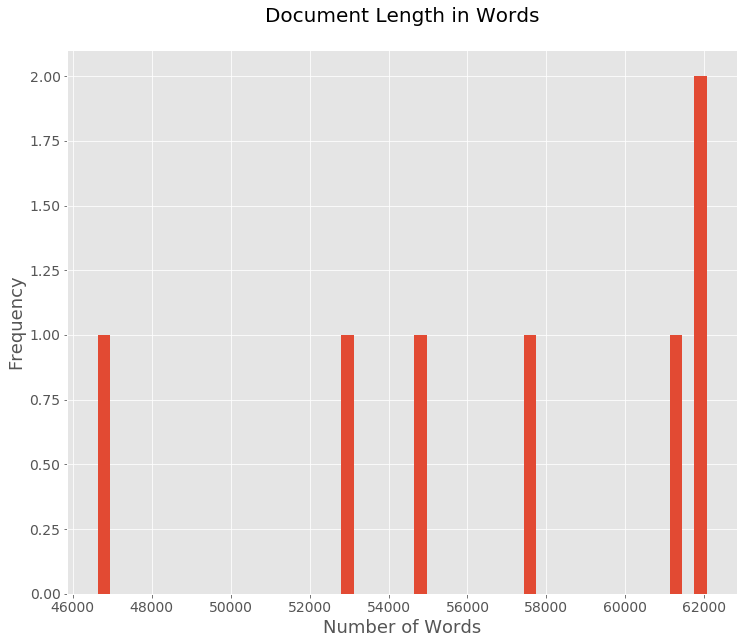

In [102]:
ax=df['num_wds'].plot(kind='hist', bins=50, fontsize=14, figsize=(12,10))
ax.set_title('Document Length in Words\n', fontsize=20)
ax.set_ylabel('Frequency', fontsize=18)
ax.set_xlabel('Number of Words', fontsize=18);

In [103]:
df['uniq_wds'] = df['content'].str.split().apply(lambda x: len(set(x)))
df['uniq_wds']

0    6110
1    5315
2    6027
3    6498
4    4781
5    5185
6    6110
Name: uniq_wds, dtype: int64

In [104]:
df['uniq_wds'].min()

4781

In [105]:
df['uniq_wds'].mean()

5718.0

In [106]:
df['uniq_wds'].max()

6498

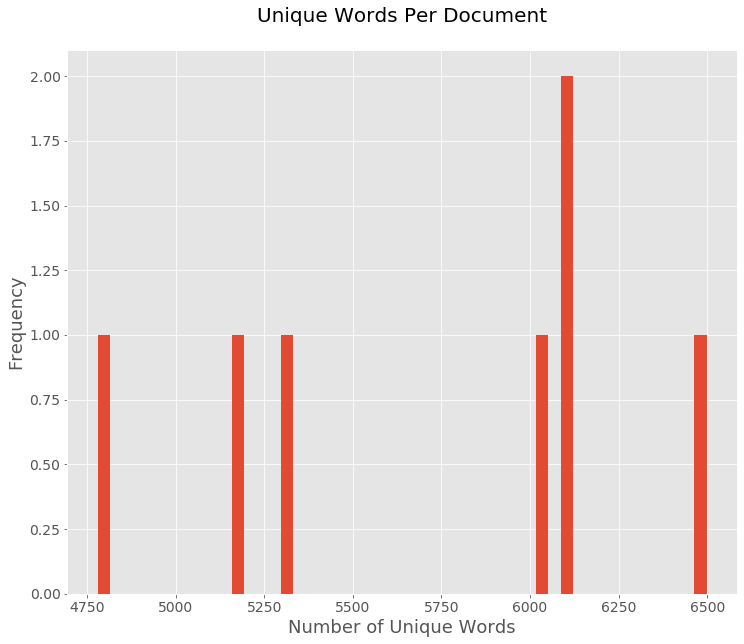

In [107]:
ax=df['uniq_wds'].plot(kind='hist', bins=50, fontsize=14, figsize=(12,10))
ax.set_title('Unique Words Per Document\n', fontsize=20)
ax.set_ylabel('Frequency', fontsize=18)
ax.set_xlabel('Number of Unique Words', fontsize=18);

In [108]:
df

,organization,content,year,num_wds,uniq_wds
0,Guilford County,guilford county numbers makes count county sta...,2020,62061,6110
1,Charlotte City,ensuring equitable sustainable resilient charl...,2020,57569,5315
2,Durham City,fiscal year adopted budget july june city durh...,2020,52919,6027
3,Durham County,approved budget durham county north carolina a...,2020,61340,6498
4,Mecklenburg County,meckncgov fiscal year adopted budget mecklenbu...,2020,54658,4781
5,Raleigh City,adopted budget strengthening foundation workfo...,2020,46635,5185
6,Wake County,guilford county numbers makes count county sta...,2020,62061,6110
